In [1]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# figure beautification
sns.set_theme(
    style='whitegrid',
    palette='deep',
    color_codes=True # access seaborn colors by changing matplotlib color shorthands
)
%config InlineBackend.figure_format = 'retina'

In [4]:
# load data
data = np.load('simulation-data.npz')
for arr in data.files:
    #globals()[arr] = data[arr]
    print(arr)

z
h
smb
xlon
ylat
nt
seamask


In [5]:
# import data
#z = data['z']
h = data['h']
#smb = data['smb']
#xlon = data['xlon']
#ylat = data['ylat']
#nt = data['nt']
#seamask = data['seamask']

In [4]:
np.shape(h)

(25000, 41, 70)

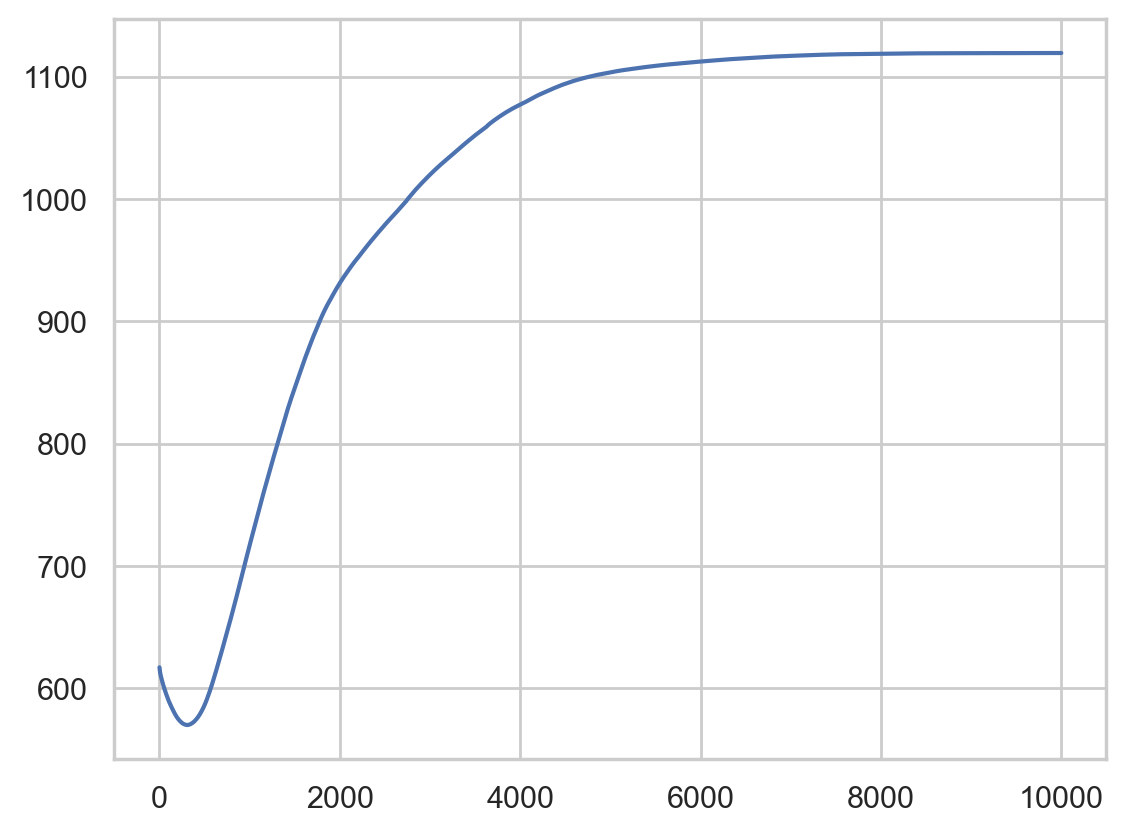

In [6]:
x = np.arange(10000)
plt.plot(x, np.mean(h, axis=(1,2)))

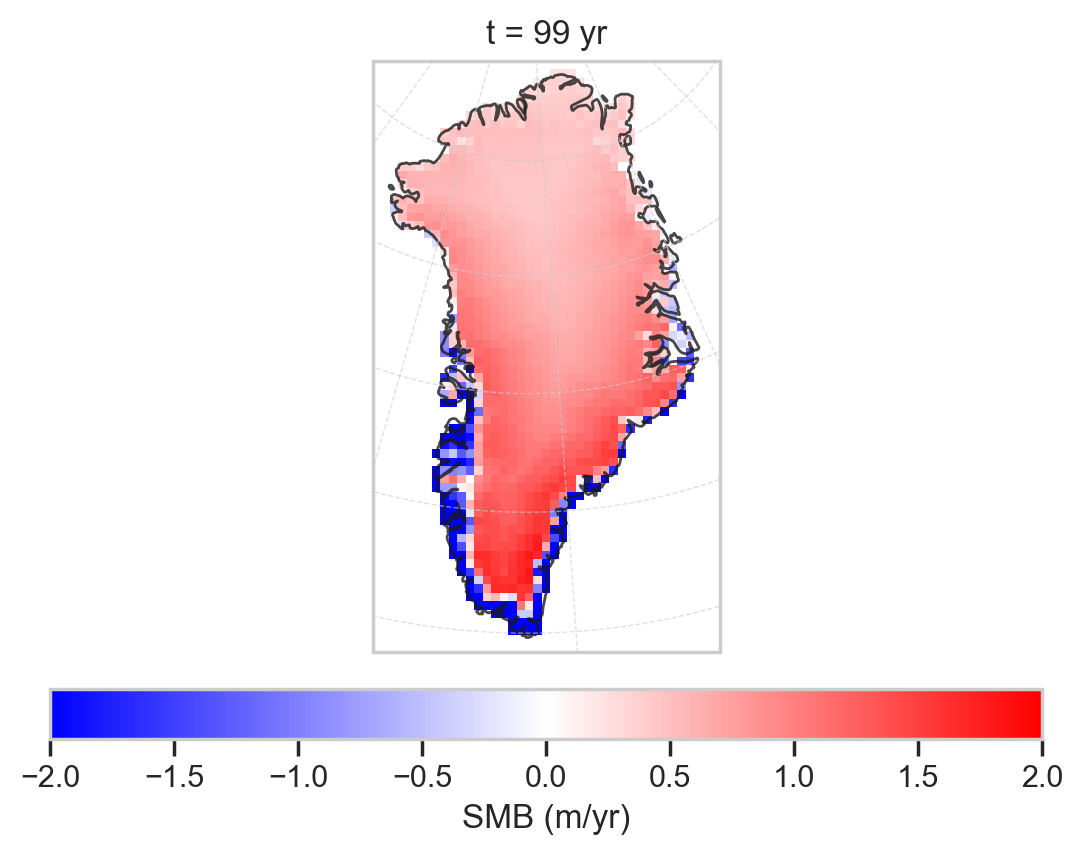

In [8]:
# plot greenland ice thickness map
trans = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=-44)

# add coastline of greenland
# get path to shapefile
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
# read shapefile
shpfile = shpreader.Reader(shpfilename)
# select greenland only
greenland = [country.geometry for country in shpfile.records() \
             if country.attributes["NAME_LONG"] == "Greenland"]

# apply ocean mask to ice thickness
smbmask = np.ma.masked_array(smb, mask=seamask)

yr = 99

fig, ax = plt.subplots(subplot_kw=dict(projection = proj))

cm = ax.pcolormesh(xlon, ylat, smbmask[yr], shading='nearest', transform=trans,
                   cmap='bwr', norm=mpl.colors.CenteredNorm())
ax.set_title(f't = {yr} yr')
    # add greenland coastline
ax.add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
ax.gridlines(alpha=.6, ls='--', lw=.5)

cbar = fig.colorbar(cm, orientation='horizontal', pad=0.05, label='SMB (m/yr)')


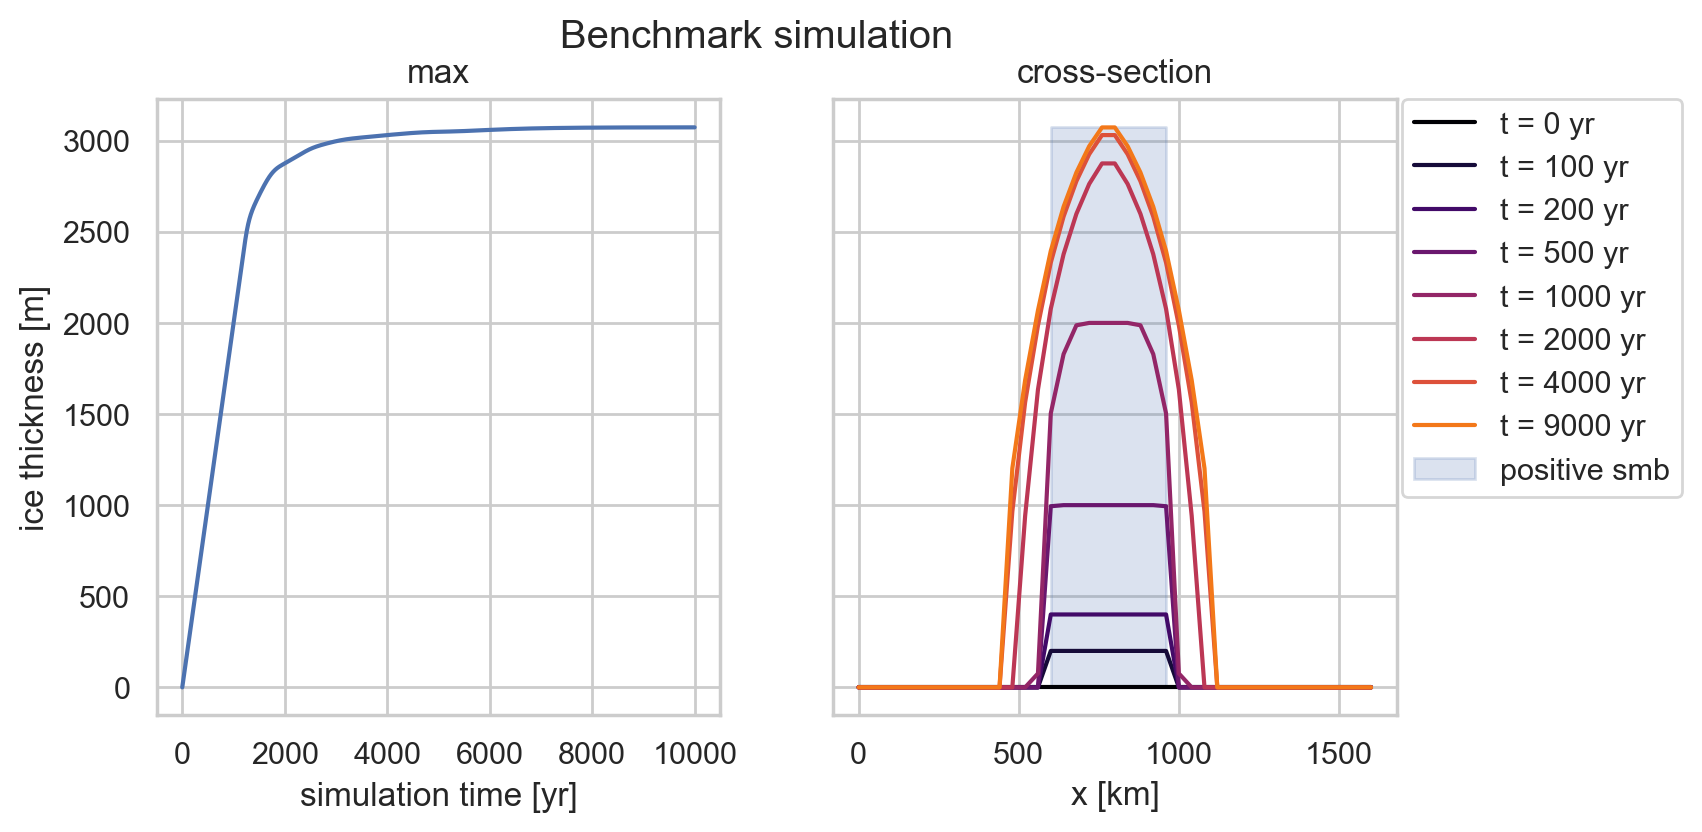

In [41]:
# quantify ice thickness
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
axs = axs.flatten()

# MAX ICE THICKNESS
t = np.arange(nt)
axs[0].plot(t, np.max(h, axis=(1,2)))
axs[0].set_xlabel('simulation time [yr]')
axs[0].set_ylabel('ice thickness [m]')
axs[0].set_title('max')

# W-E SECTION THROUGH THE MIDDLE OF THE DOMAIN
# (round middle index to nearest integer)
x = np.arange(h.shape[1])*40 # 40 km grid spacing
centerx = h.shape[1] // 2
centery = h.shape[2] // 2
hsec = h[:, :, centery]
# arbritrary time slices
range = [0, 100, 200, 500, 1000, 2000, 4000, 9000]
# get the colormap
cmap = mpl.colormaps['inferno']
for i, yr in enumerate(range):
    # pick a color from the colormap
    color = cmap(i / (len(range)+2))
    axs[1].plot(x, hsec[yr, :], color=color, label=f't = {yr} yr')
# indicate smb boundaries
x_fill = np.linspace((centerx-5)*40, (centerx+4)*40, 100)
axs[1].fill_between(x_fill, np.max(h), color='b', alpha=.2, label='positive smb')

axs[1].set_xlabel('x [km]')
axs[1].set_title('cross-section')   

fig.suptitle('Benchmark simulation')
fig.legend(bbox_to_anchor=(1.088, 0.9))
plt.savefig('figs/cross-section.png', dpi=300, bbox_inches='tight')

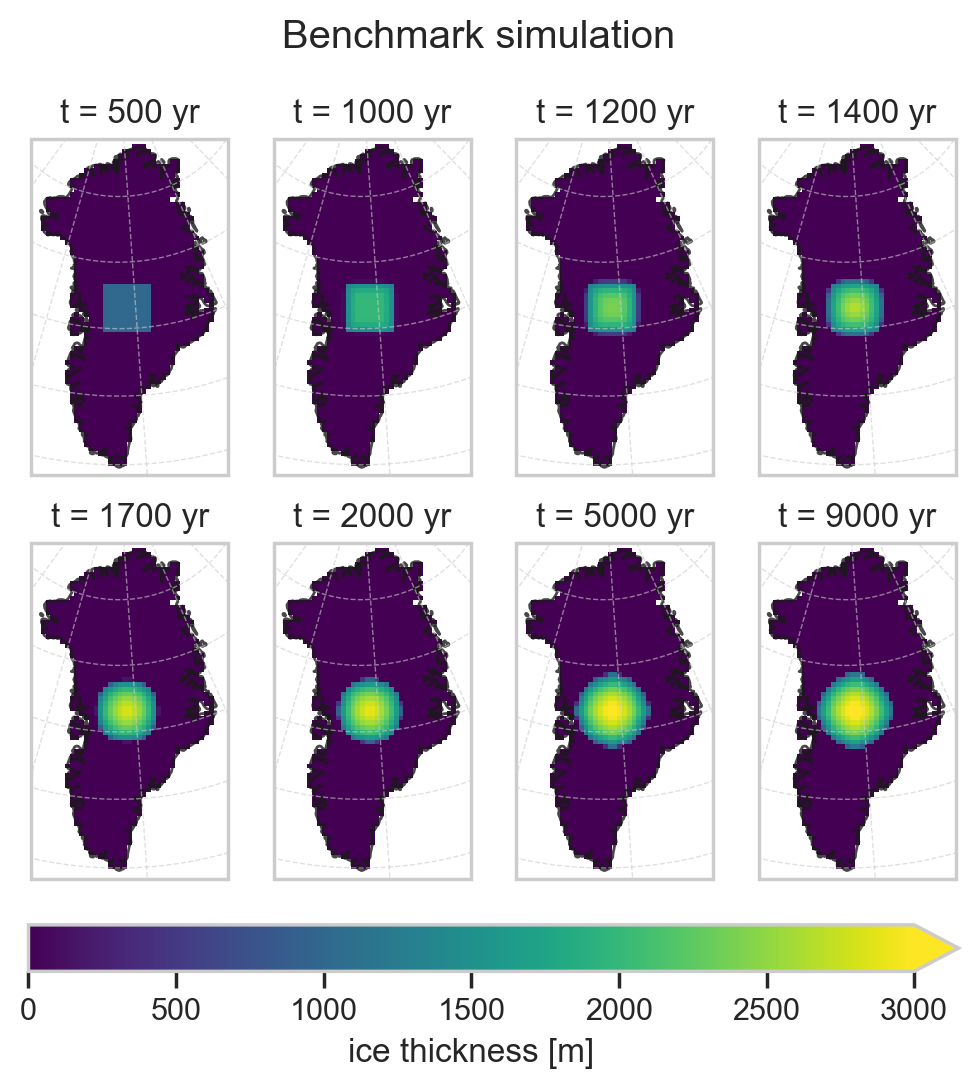

In [42]:
# arbritrary time slices
range = [500, 1000, 1200, 1400, 1700, 2000, 5000, 9000]

# apply ocean mask to ice thickness
hmask = np.ma.masked_array(h, mask=seamask)

# plot greenland ice thickness map
trans = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=-44)

# add coastline of greenland
# get path to shapefile
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
# read shapefile
shpfile = shpreader.Reader(shpfilename)
# select greenland only
greenland = [country.geometry for country in shpfile.records() \
             if country.attributes["NAME_LONG"] == "Greenland"]
    
fig, axs = plt.subplots(2, 4, subplot_kw=dict(projection = proj), figsize=(6, 6))
axs = axs.flatten()

for i, yr in enumerate(range):
    cm = axs[i].pcolormesh(xlon, ylat, hmask[yr], cmap='viridis',
                           shading='nearest', transform=trans,
                           norm=mpl.colors.Normalize(vmin=0, vmax=3000))
    axs[i].set_title(f't = {yr} yr')
    # add greenland coastline
    axs[i].add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
    axs[i].gridlines(alpha=.6, ls='--', lw=.5)

fig.suptitle('Benchmark simulation')
cbar = fig.colorbar(cm, orientation='horizontal', pad=0.05, extend='max', ax=axs)
cbar.set_label('ice thickness [m]')
plt.savefig('figs/ice-map.png', dpi=300, bbox_inches='tight')